In [1]:
from Pneumotracker_func import get_and_create_dirs, build_df, add_resized_image, plot_tsne_svc, plot_lda, build_train_model, model_smpl, model_cmpl, segment_image, dice_coef_loss, dice_coef, get_heatmap_gradcam, lime_heatmap, lime_outline, plot_interpretability_grid

import os
import pandas as pd
from keras.models import load_model
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

orig_path, seg_path = r'.\chest_xray', r'.\segmentation'
orig_file_ext, seg_file_ext = 'jpeg', 'png'
smpl_checkp_name = r'.\Models\model_simple_orig_224_rgb.h5'
smpl_hist_name = r'.\Models\history_simple_orig_224_rgb.csv'
seg_model = r'.\Models\unet_lung_seg.hdf5'
cmpl_orig_checkp_name = r'.\Models\model_complex_orig_224_rgb.h5'
cmpl_orig_hist_name = r'.\Models\history_complex_orig_224_rgb.csv'
cmpl_seg_checkp_name = r'.\Models\model_complex_seg_224_rgb.h5'
cmpl_seg_hist_name = r'.\Models\history_complex_seg_224_rgb.csv'

In [2]:
print('Press Enter for each input cell to pass default value.')

Press Enter for each input cell to pass default value.


## I. Intialize variables

In [3]:
orig_path, seg_path, orig_file_ext, seg_model, seg_file_ext = get_and_create_dirs()

Checks for paths for original and segmented images.
Original and segmented images folders must be organized in the exact same structure (images in the same folders and sub-folders).

Input root path for original images (default github folder):


Input root path for segmented images if exists or needs to be created (default github folder):


What is the file extension for original images (default jpeg) ?


What is the path to the segmentation model checkpoint (default github folder) ?


What is the file extension for segmented images (default png) ?



## II. Build dataset DataFrame

In [4]:
print('Building dataset DataFrame')

df = build_df(path_orig = orig_path,
              orig_file_ext = orig_file_ext,
              path_seg = seg_path,
              seg_file_ext = seg_file_ext,
              save_path = r'.\Dfs\df_all.csv')

df.head()

Building dataset DataFrame
DataFrame was found, would you like to read it (R) or recreate it (C) (default Read)?



,Label_name,Label_int,Label_pathology,Label_pathology_int,Filename_orig,Filepath_orig,Filename_seg,Filepath_seg
0,PNEUMONIA,1,bacteria,1,person1947_bacteria_4876.jpeg,.\chest_xray\val\PNEUMONIA\person1947_bacteria...,person1947_bacteria_4876.png,.\segmentation\val\PNEUMONIA\person1947_bacter...
1,PNEUMONIA,1,bacteria,1,person1946_bacteria_4875.jpeg,.\chest_xray\val\PNEUMONIA\person1946_bacteria...,person1946_bacteria_4875.png,.\segmentation\val\PNEUMONIA\person1946_bacter...
2,PNEUMONIA,1,bacteria,1,person1952_bacteria_4883.jpeg,.\chest_xray\val\PNEUMONIA\person1952_bacteria...,person1952_bacteria_4883.png,.\segmentation\val\PNEUMONIA\person1952_bacter...
3,PNEUMONIA,1,bacteria,1,person1954_bacteria_4886.jpeg,.\chest_xray\val\PNEUMONIA\person1954_bacteria...,person1954_bacteria_4886.png,.\segmentation\val\PNEUMONIA\person1954_bacter...
4,PNEUMONIA,1,bacteria,1,person1951_bacteria_4882.jpeg,.\chest_xray\val\PNEUMONIA\person1951_bacteria...,person1951_bacteria_4882.png,.\segmentation\val\PNEUMONIA\person1951_bacter...


#### Necessary to ensure same data split between file systems

In [5]:
df = pd.read_csv(r'.\Dfs\df_all.csv', index_col = 0)
df.head()

,Label_name,Label_int,Label_pathology,Label_pathology_int,Filename_orig,Filepath_orig,Filename_seg,Filepath_seg
0,PNEUMONIA,1,bacteria,1,person1947_bacteria_4876.jpeg,.\chest_xray\val\PNEUMONIA\person1947_bacteria...,person1947_bacteria_4876.png,.\segmentation\val\PNEUMONIA\person1947_bacter...
1,PNEUMONIA,1,bacteria,1,person1946_bacteria_4875.jpeg,.\chest_xray\val\PNEUMONIA\person1946_bacteria...,person1946_bacteria_4875.png,.\segmentation\val\PNEUMONIA\person1946_bacter...
2,PNEUMONIA,1,bacteria,1,person1952_bacteria_4883.jpeg,.\chest_xray\val\PNEUMONIA\person1952_bacteria...,person1952_bacteria_4883.png,.\segmentation\val\PNEUMONIA\person1952_bacter...
3,PNEUMONIA,1,bacteria,1,person1954_bacteria_4886.jpeg,.\chest_xray\val\PNEUMONIA\person1954_bacteria...,person1954_bacteria_4886.png,.\segmentation\val\PNEUMONIA\person1954_bacter...
4,PNEUMONIA,1,bacteria,1,person1951_bacteria_4882.jpeg,.\chest_xray\val\PNEUMONIA\person1951_bacteria...,person1951_bacteria_4882.png,.\segmentation\val\PNEUMONIA\person1951_bacter...


## III. Dimension reduction (original images)

#### III.1. Resizing images for dimension reduction

In [6]:
img_re_size = (24, 24)
img_re_size = (input('Height of resized images (default 24):\n') or img_re_size[0],
               input('Width of resized images (default 24):\n') or img_re_size[1])

df_orig_resized = add_resized_image(df = df.loc[:, ['Label_name', 'Label_int', 'Filepath_orig']].copy(),
                                    filepath_col = 'Filepath_orig',
                                    size = img_re_size,
                                    save_path = r'.\Dfs\df_orig_resized_24.csv')

df_orig_resized.head()

Height of resized images (default 24):

Width of resized images (default 24):

DataFrame was found, would you like to read it (R) or recreate it (C) (default Read)?



,Label_name,Label_int,Filepath_orig,0,1,2,3,4,5,6,...,566,567,568,569,570,571,572,573,574,575
0,PNEUMONIA,1,.\chest_xray\val\PNEUMONIA\person1947_bacteria...,106.0,97.0,147.0,155.0,147.0,129.0,188.0,...,205.0,203.0,201.0,198.0,186.0,174.0,164.0,90.0,0.0,0.0
1,PNEUMONIA,1,.\chest_xray\val\PNEUMONIA\person1946_bacteria...,1.0,127.0,8.0,36.0,94.0,147.0,167.0,...,177.0,169.0,173.0,169.0,150.0,136.0,87.0,9.0,6.0,8.0
2,PNEUMONIA,1,.\chest_xray\val\PNEUMONIA\person1952_bacteria...,45.0,47.0,86.0,48.0,88.0,93.0,124.0,...,196.0,195.0,198.0,196.0,191.0,183.0,152.0,23.0,0.0,2.0
3,PNEUMONIA,1,.\chest_xray\val\PNEUMONIA\person1954_bacteria...,1.0,17.0,44.0,114.0,113.0,66.0,21.0,...,200.0,202.0,187.0,175.0,168.0,133.0,0.0,0.0,0.0,0.0
4,PNEUMONIA,1,.\chest_xray\val\PNEUMONIA\person1951_bacteria...,0.0,248.0,253.0,80.0,130.0,175.0,189.0,...,189.0,192.0,187.0,187.0,180.0,166.0,105.0,6.0,11.0,105.0


#### III.2. SVC decision region for TSNE reduced images

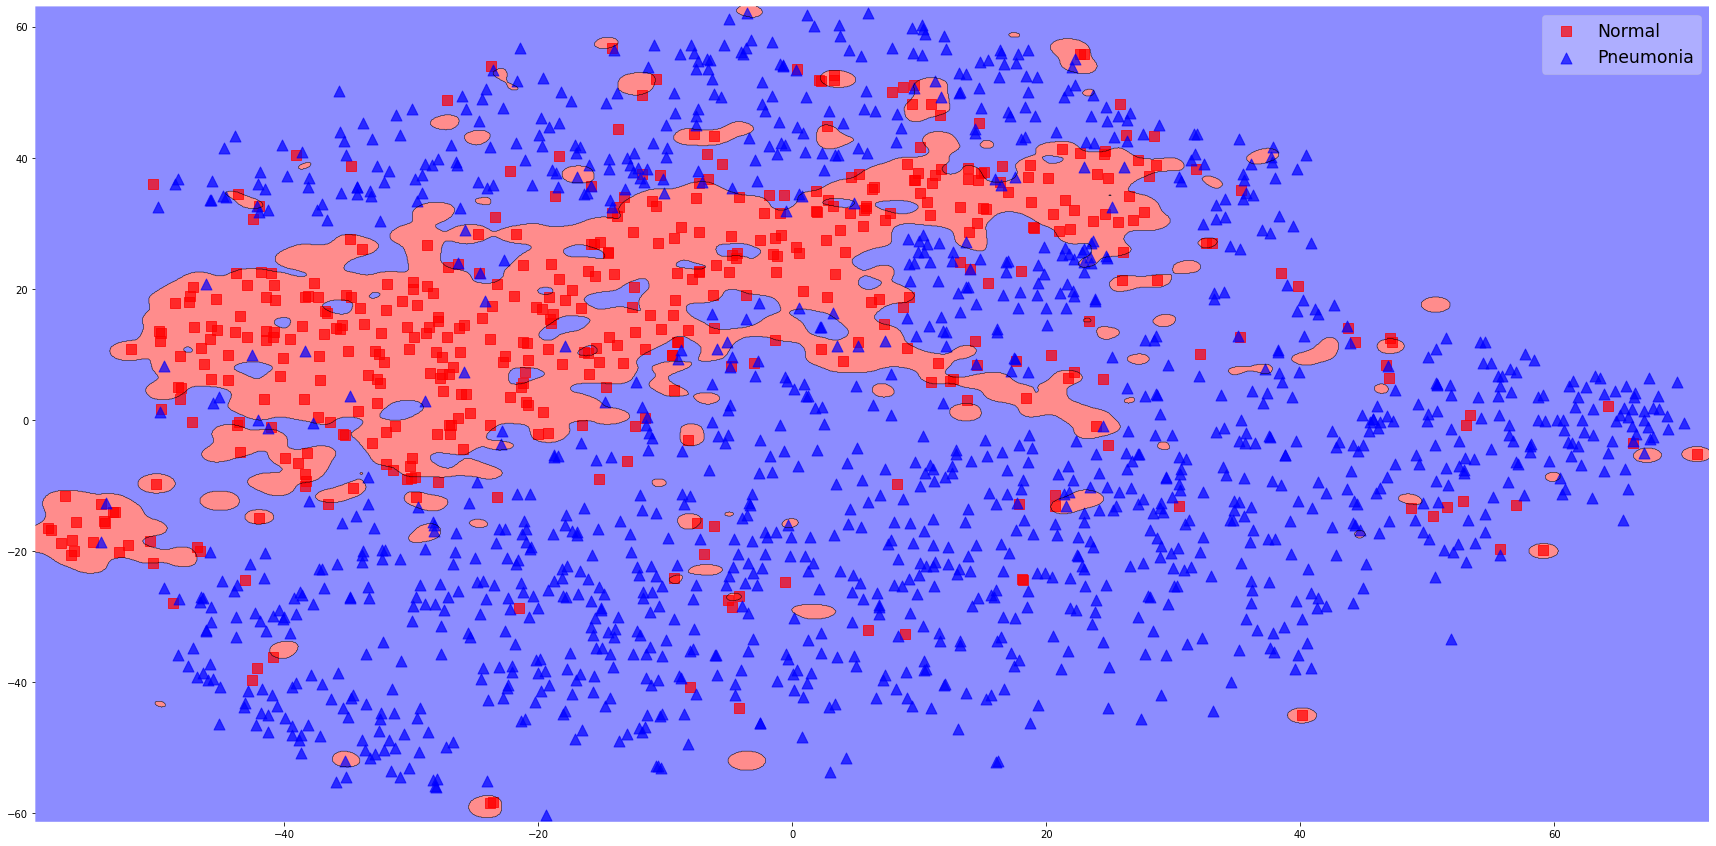

In [7]:
plot_tsne_svc(df_orig_resized.loc[:, 0:(img_re_size[0] * img_re_size[0] - 1)],
              df_orig_resized['Label_int'],
              {0 : 'Normal', 1 : 'Pneumonia'},
              'SVC decision regions for TSNE reduced original images')

#### III.3. LDA projection with original images

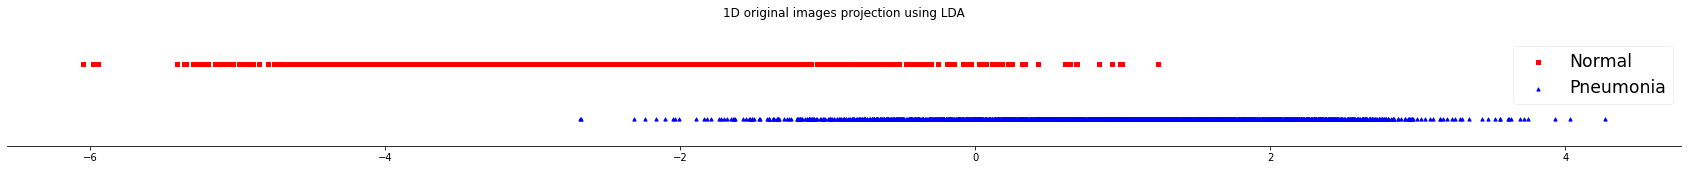

In [7]:
plot_lda(df_orig_resized.loc[:, 0:(img_re_size[0] * img_re_size[0] - 1)],
         df_orig_resized['Label_int'],
         {0 : 'Normal', 1 : 'Pneumonia'},
         '1D original images projection using LDA')

## IV. Building and training simple CNN

In [ ]:
smpl_checkp_name = input('Input path for simple model checkpoint (XXXX.h5) (default github checkpoint path).\n') or r'.\Models\model_simple_orig_224_rgb.h5'
smpl_hist_name = input('Input path for simple model history (XXXX.csv) (default github history path).\n') or r'.\Models\history_simple_orig_224_rgb.csv'

train = False

if 'smpl_checkp_name' in locals():
    if os.path.exists(smpl_checkp_name):
        train = True if (input('Simple model checkpoint found. Do you want to retrain model (Y/N, default N)?') or 'N') == 'Y' else False
    else:
        train = True
else:
    train = True    

X_colname = 'Filepath_orig'
Y_colname = 'Label_name'

if 'df_test_glob' in locals():
    md_smpl_eval, history_smpl, smpl_model_class_rep, smpl_model_conf_mat, smpl_orig_model, df_test_glob = build_train_model(df, X_colname, Y_colname, model_smpl, 2, 32, 30, smpl_checkp_name, smpl_hist_name, train, df_test_glob)
else:
    md_smpl_eval, history_smpl, smpl_model_class_rep, smpl_model_conf_mat, smpl_orig_model, df_test_glob = build_train_model(df, X_colname, Y_colname, model_smpl, 2, 32, 30, smpl_checkp_name, smpl_hist_name, train)

In [ ]:
df_test_glob.head()

#### IV.1.Training history

In [ ]:
plt.plot(history_smpl.index + 1, history_smpl['accuracy'], color = 'royalblue', linestyle = '--', label = 'Train accuracy')
plt.plot(history_smpl.index + 1, history_smpl['val_accuracy'], color = 'red', linestyle = '--', label = 'Val accuracy')
plt.ylim([0, 1.0])
plt.xticks([5, 10, 15, 20])
plt.legend(loc = 'best')
plt.title('Training vs val accuracy for simple model', pad = 20)
;

#### IV.2. Classification report

In [ ]:
smpl_model_class_rep

#### IV.3. Confusion matrix

In [ ]:
smpl_model_conf_mat

## V. Building and training complex CNN with original images

In [ ]:
cmpl_orig_checkp_name = input('Input path for complex model with original images checkpoint (XXXX.h5) (default github checkpoint path).\n') or r'.\Models\model_complex_orig_224_rgb.h5'
cmpl_orig_hist_name = input('Input path for complex model with original images history (XXXX.csv) (default github history path).\n') or r'.\Models\history_complex_orig_224_rgb.csv'

train = False

if 'cmpl_orig_checkp_name' in locals():
    if os.path.exists(cmpl_orig_checkp_name):
        train = True if (input('Complex model with original images checkpoint found. Do you want to retrain model (Y/N, default N)?') or 'N') == 'Y' else False
    else:
        train = True
else:
    train = True    

X_colname = 'Filepath_orig'
Y_colname = 'Label_name'

if 'df_test_glob' in locals():
    md_cmpl_orig_eval, history_cmpl_orig, cmpl_orig_model_class_rep, cmpl_orig_model_conf_mat, cmpl_orig_model, df_test_glob = build_train_model(df, X_colname, Y_colname, model_cmpl, 2, 32, 30, cmpl_orig_checkp_name, cmpl_orig_hist_name, train, df_test_glob)
else:
    md_cmpl_orig_eval, history_cmpl_orig, cmpl_orig_model_class_rep, cmpl_orig_model_conf_mat, cmpl_orig_model, df_test_glob = build_train_model(df, X_colname, Y_colname, model_cmpl, 2, 32, 30, cmpl_orig_checkp_name, cmpl_orig_hist_name, train)

#### V.1. Training history

In [ ]:
plt.plot(history_cmpl_orig.index, history_cmpl_orig['accuracy'], color = 'royalblue', linestyle = '--', label = 'Train accuracy')
plt.plot(history_cmpl_orig.index, history_cmpl_orig['val_accuracy'], color = 'red', linestyle = '--', label = 'Val accuracy')
plt.ylim([0, 1.0])
plt.xticks([5, 10, 15, 20])
plt.legend(loc = 'best')
plt.title('Training vs val accuracy for complex model with original images', pad = 20)
;

#### V.2. Classification report

In [ ]:
cmpl_orig_model_class_rep

#### V.3. Confusion matrix

In [ ]:
cmpl_orig_model_conf_mat

## VI. Segmenting images using UNET model

In [ ]:
segmentation_model = load_model(seg_model, 
                                custom_objects={'dice_coef_loss': dice_coef_loss,
                                                'dice_coef': dice_coef})

segmentation_model.summary()

In [ ]:
if (input('Do you want to segment images with UNET model (Y/N, default N)?\n') or 'N') == 'Y':
    print('Segmenting images and saving to', seg_path, '...')
    for dirname, _, filenames in os.walk(orig_path):
        for filename in tqdm(filenames):
            if ('.' + orig_file_ext) in filename:
                segment_image(segmentation_model, os.path.join(dirname, filename), dirname.replace(orig_path, seg_path))

## VII. Dimension reduction (segmented images)

#### VII.1. Resizing images for dimension reduction

In [11]:
img_re_size = (24, 24)
img_re_size = (input('Height of resized images (default 24):\n') or img_re_size[0],
               input('Width of resized images (default 24):\n') or img_re_size[1])

df_orig_resized = add_resized_image(df = df.loc[:, ['Label_name', 'Label_int', 'Filepath_seg']].copy(),
                                    filepath_col = 'Filepath_seg',
                                    size = img_re_size,
                                    save_path = r'.\Dfs\df_seg_resized_24.csv')

df_orig_resized.head()

Height of resized images (default 24):

Width of resized images (default 24):

DataFrame was found, would you like to read it (R) or recreate it (C) (default Read)?



,Label_name,Label_int,Filepath_seg,0,1,2,3,4,5,6,...,566,567,568,569,570,571,572,573,574,575
0,PNEUMONIA,1,.\segmentation\val\PNEUMONIA\person1947_bacter...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PNEUMONIA,1,.\segmentation\val\PNEUMONIA\person1946_bacter...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PNEUMONIA,1,.\segmentation\val\PNEUMONIA\person1952_bacter...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PNEUMONIA,1,.\segmentation\val\PNEUMONIA\person1954_bacter...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PNEUMONIA,1,.\segmentation\val\PNEUMONIA\person1951_bacter...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### VII.2. SVC decision region for TSNE reduced images

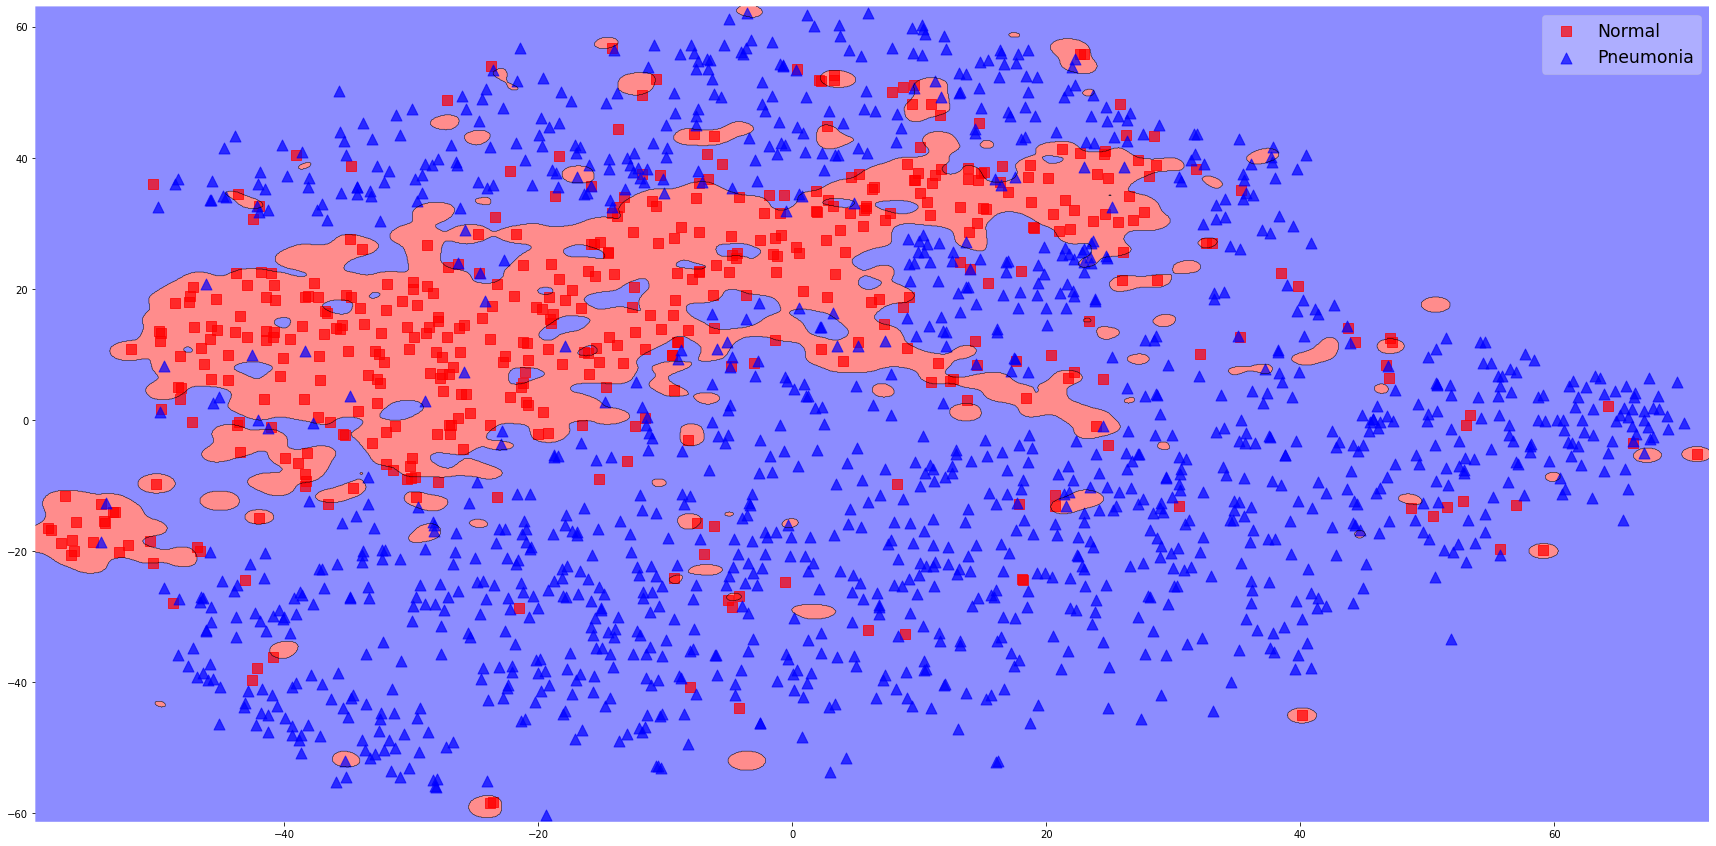

In [7]:
plot_tsne_svc(df_orig_resized.loc[:, 0:(img_re_size[0] * img_re_size[0] - 1)],
              df_orig_resized['Label_int'],
              {0 : 'Normal', 1 : 'Pneumonia'},
              'SVC decision regions for TSNE reduced segmented images')

#### VII.3. LDA projection with original images

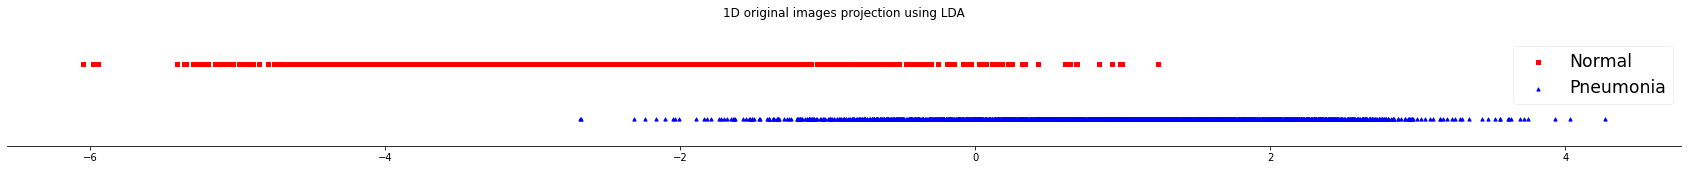

In [7]:
plot_lda(df_orig_resized.loc[:, 0:(img_re_size[0] * img_re_size[0] - 1)],
         df_orig_resized['Label_int'],
         {0 : 'Normal', 1 : 'Pneumonia'},
         '1D segmented images projection using LDA')

## VIII. Building and training complex CNN with segmented images

In [ ]:
cmpl_seg_checkp_name = input('Input path for complex model with segmented images checkpoint (XXXX.h5) (default github checkpoint path).\n') or r'.\Models\model_complex_seg_224_rgb.h5'
cmpl_seg_hist_name = input('Input path for complex model with segmented history (XXXX.csv) (default github history path).\n') or r'.\Models\history_complex_seg_224_rgb.csv'

train = False

if 'smpl_checkp_name' in locals():
    if os.path.exists(cmpl_seg_checkp_name):
        train = True if (input('Complex model with segmented checkpoint found. Do you want to retrain model (Y/N, default N)?\n') or 'N') == 'Y' else False
    else:
        train = True
else:
    train = True    

X_colname = 'Filepath_seg'
Y_colname = 'Label_name'

if 'df_test_glob' in locals():
    md_cmpl_seg_eval, history_cmpl_seg, cmpl_seg_model_class_rep, cmpl_seg_model_conf_mat, cmpl_seg_model, df_test_glob = build_train_model(df, X_colname, Y_colname, model_cmpl, 2, 32, 30, cmpl_seg_checkp_name, cmpl_seg_hist_name, train, df_test_glob)
else:
    md_cmpl_seg_eval, history_cmpl_seg, cmpl_seg_model_class_rep, cmpl_seg_model_conf_mat, cmpl_seg_model, df_test_glob = build_train_model(df, X_colname, Y_colname, model_cmpl, 2, 32, 30, cmpl_seg_checkp_name, cmpl_seg_hist_name, train)

In [ ]:
df_test_glob.head()

#### VIII.1. Training history

In [ ]:
plt.plot(history_cmpl_seg.index + 1, history_cmpl_seg['accuracy'], color = 'royalblue', linestyle = '--', label = 'Train accuracy')
plt.plot(history_cmpl_seg.index + 1, history_cmpl_seg['val_accuracy'], color = 'red', linestyle = '--', label = 'Val accuracy')
plt.ylim([0, 1.0])
plt.xticks([5, 10, 15, 20])
plt.legend(loc = 'best')
plt.title('Training vs val accuracy for complex model with segmented images', pad = 20)
;

#### VIII.2. Classification report

In [ ]:
cmpl_seg_model_class_rep

#### VIII.3. Confusion matrix

In [ ]:
cmpl_seg_model_conf_mat

## IX. Interpretability

In [ ]:
img_list_orig = ['person34_virus_76.jpeg', 'person39_bacteria_198.jpeg',
                 'person78_bacteria_385.jpeg', 'person83_bacteria_409.jpeg']
img_list_seg = ['person34_virus_76.png', 'person39_bacteria_198.png',
                'person78_bacteria_385.png', 'person83_bacteria_409.png']

smpl_orig_model_last_conv = 'conv2d_1'
cmpl_orig_model_last_conv = 'conv2d_29'
cmpl_seg_model_last_conv = 'conv2d_169'

#### IX.1. Simple model with original images

##### IX.1.a. Grad-Cam

In [ ]:
plot_interpretability_grid('gradcam',
                           smpl_orig_model,
                           df_test_glob,
                           filepath_col = 'Filepath_orig',
                           filename_col = 'Filename_orig',
                           class_col = 'Label_name',
                           pred_col = 'predicted_str_smpl_orig',
                           img_list = img_list_orig,
                           nb_img = None,
                           last_conv_layer_name = smpl_orig_model_last_conv,
                           grad_quant = 0.5,
                           alpha = 0.7)

##### IX.1.b. Lime

In [ ]:
plot_interpretability_grid('lime',
                           smpl_orig_model,
                           df_test_glob,
                           filepath_col = 'Filepath_orig',
                           filename_col = 'Filename_orig',
                           class_col = 'Label_name',
                           pred_col = 'predicted_str_smpl_orig',
                           img_list = img_list_orig,
                           nb_img = None,
                           last_conv_layer_name = smpl_orig_model_last_conv,
                           grad_quant = 0.5,
                           alpha = 0.7)

#### IX.2. Complex model with original images

##### IX.2.a. Grad-Cam

In [ ]:
plot_interpretability_grid('gradcam',
                           cmpl_seg_model,
                           df_test_glob,
                           filepath_col = 'Filepath_orig',
                           filename_col = 'Filename_orig',
                           class_col = 'Label_name',
                           pred_col = 'predicted_str_cmpl_orig',
                           img_list = img_list_orig,
                           nb_img = None,
                           last_conv_layer_name = cmpl_orig_model_last_conv,
                           grad_quant = 0.5,
                           alpha = 0.7)

##### IX.2.b. Lime

In [ ]:
plot_interpretability_grid('lime',
                           cmpl_orig_model,
                           df_test_glob,
                           filepath_col = 'Filepath_orig',
                           filename_col = 'Filename_orig',
                           class_col = 'Label_name',
                           pred_col = 'predicted_str_cmpl_orig',
                           img_list = img_list_orig,
                           nb_img = None,
                           last_conv_layer_name = cmpl_orig_model_last_conv,
                           grad_quant = 0.5,
                           alpha = 0.7)

#### IX.3. Complex model with segmented images

##### IX.3.a. Grad-Cam

In [ ]:
plot_interpretability_grid('gradcam',
                           cmpl_seg_model,
                           df_test_glob,
                           filepath_col = 'Filepath_seg',
                           filename_col = 'Filename_seg',
                           class_col = 'Label_name',
                           pred_col = 'predicted_str_cmpl_seg',
                           img_list = img_list_seg,
                           nb_img = None,
                           last_conv_layer_name = cmpl_seg_model_last_conv,
                           grad_quant = 0.5,
                           alpha = 0.7)

##### IX.3.b. Lime

In [ ]:
plot_interpretability_grid('lime',
                           cmpl_seg_model,
                           df_test_glob,
                           filepath_col = 'Filepath_seg',
                           filename_col = 'Filename_seg',
                           class_col = 'Label_name',
                           pred_col = 'predicted_str_cmpl_seg',
                           img_list = img_list_seg,
                           nb_img = None,
                           last_conv_layer_name = cmpl_seg_model_last_conv,
                           grad_quant = 0.5,
                           alpha = 0.7)